# **[Project] Cancer Subtype Classification**

# Introduction

The [TCGA Kidney Cancers Dataset](https://archive.ics.uci.edu/dataset/892/tcga+kidney+cancers) is a bulk RNA-seq dataset that contains transcriptome profiles (i.e., gene expression quantification data) of patients diagnosed with three different subtypes of kidney cancers.
This dataset can be used to make predictions about the specific subtype of kidney cancers given the normalized transcriptome profile data.

The normalized transcriptome profile data is given as **TPM** and **FPKM** for each gene.

> TPM (Transcripts Per Million) and FPKM (Fragments Per Kilobase Million) are two common methods for quantifying gene expression in RNA sequencing data.
> They both aim to account for the differences in sequencing depth and transcript length when estimating gene expression levels.
>
> **TPM** (Transcripts Per Million):
> - TPM is a measure of gene expression that normalizes for both library size (sequencing depth) and transcript length.
> - The main idea behind TPM is to express the abundance of a transcript relative to the total number of transcripts in a sample, scaled to one million.
>
> **FPKM** (Fragments Per Kilobase Million):
> - FPKM is another method for quantifying gene expression, which is commonly used in older RNA-seq analysis pipelines. It's similar in concept to TPM but differs in the way it's calculated.
> - FPKM also normalizes for library size and transcript length, but it measures gene expression as the number of fragments (i.e., reads) per kilobase of exon model per million reads.
>
> TPM is generally considered more robust to variations in library size, making it a preferred choice in many modern RNA-seq analysis workflows.

We provide one dataset for each kidney cancer subtype:

- [TCGA-KICH](https://portal.gdc.cancer.gov/projects/TCGA-KICH): kidney chromophobe (renal clear cell carcinoma)
- [TCGA-KIRC](https://portal.gdc.cancer.gov/projects/TCGA-KIRC): kidney renal clear cell carcinoma
- [TCGA-KIRP](https://portal.gdc.cancer.gov/projects/TCGA-KIRP): kidney renal papillary cell carcinoma

> This and _much_ more data is openly available on the [NCI Genomic Data Commons (GDC) Data Portal](https://portal.gdc.cancer.gov/).

# Load dataset

In [48]:
# ignore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

All given feature are normalized transcriptome profiles, given as **TPM** and **FPKM** for each gene.

In [49]:
feature_colums = ['unstranded', 'stranded_first', 'stranded_second', 'tpm_unstranded', 'fpkm_unstranded', 'fpkm_uq_unstranded']
feature_colum = "tpm_unstranded"

FONTSIZE = 16

SEED = 2

In [50]:
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from typing import List, Tuple, NamedTuple, Dict
import os
import numpy as np
import pandas as pd
import pickle


In [51]:
missing_files = []
class_path = {"tcga-kich-geq": "gdc_manifest.tcga-kich-geq.txt", 
              "tcga-kirc-geq": "gdc_manifest.tcga-kirc-geq.txt", 
              "tcga-kirp-geq": "gdc_manifest.tcga-kirp-geq.txt"}

def load_data(feature_column: str, save: bool = True) -> pd.DataFrame:
    # check if dataset already exists
    file = f"data/datasets/tcga_{feature_column}.csv"
    if os.path.isfile(file):
        print(f"Loading dataset from {file}")
        return pd.read_csv(file)
    
    X = []
    y = []
    sample_count = 0

    for key, value in class_path.items():
        manifest_filepath = os.path.join("data", key, value)

        # manifest contains the file id (=foldername) and file name of each sample, so we can load the data
        manifest = pd.read_csv(filepath_or_buffer=manifest_filepath, sep="\t", header=0)

        for sample in manifest.iterrows():
            file_id, file_name = sample[1]["id"], sample[1]["filename"]
            file_path = os.path.join("data", key, file_id, file_name)

            if not os.path.isfile(file_path):
                print(f"File {file_path} does not exist")
                continue
                
            genom_profil = pd.read_csv(file_path, sep="\t", header=1, skiprows=[2,3,4,5])
            features = genom_profil[feature_column].values
      
            assert len(features) == 60660 # source: https://archive.ics.uci.edu/dataset/892/tcga+kidney+cancers, features: 60660 

            if sample_count == 0:
                reference_feature_names = genom_profil["gene_name"].values
            else:
                assert np.array_equal(reference_feature_names, genom_profil["gene_name"].values)

            X.append(features)
            y.append(key)

            sample_count += 1

    dataset = pd.DataFrame(X, columns=reference_feature_names)
    dataset["class"] = y

    if save:
        dataset.to_csv(file, index=False)

    return dataset

In [52]:
df = load_data(feature_colum)
df.head(2)

Loading dataset from data/datasets/tcga_tpm_unstranded.csv


,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,...,AC092910.4,AC073611.1,AC136977.1,AC078856.1,AC008763.4,AL592295.6,AC006486.3,AL391628.1,AP006621.6,class
0,55.9520,4.3021,83.0649,4.2308,1.6038,1.2908,0.6652,41.0652,19.2725,9.6328,...,0.0,0.1045,0.0,0.0,0.0,10.9815,0.0,0.0361,0.1181,tcga-kich-geq
1,12.3718,0.2012,43.2066,1.3020,0.3572,3.3282,7.9863,24.6686,7.6894,4.7810,...,0.0,0.0995,0.0,0.0,0.0,4.9445,0.0,0.0140,0.1928,tcga-kich-geq


Dataset contains of about 1000 samples and 60000 features.

# Explore dataset and analyze data

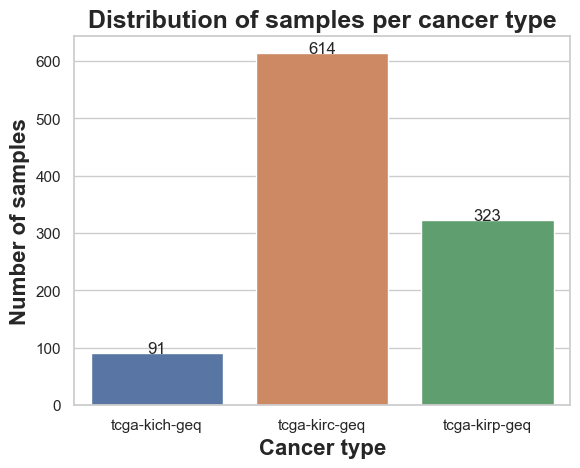

In [53]:
# plot distribution of classes
# count number of samples per class
def plot_class_distribution(df: pd.DataFrame):
    class_counts = Counter(df["class"])

    sns.set(style="whitegrid")
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
    # sns.set(rc={'figure.figsize':(6,5)})

    # title in bold
    plt.title("Distribution of samples per cancer type", fontweight="bold", fontsize=FONTSIZE + 2)
    plt.ylabel("Number of samples", fontweight="bold", fontsize=FONTSIZE)
    plt.xlabel("Cancer type", fontweight="bold", fontsize=FONTSIZE)

    #plot value above the bar
    for index, value in enumerate(class_counts.values()):
        plt.text(index, value, str(value), ha="center")

    plt.show()

plot_class_distribution(df)

We can state that the dataset is imbalanced, since the number of samples for each class is not equal.
Therefore we have different options to deal with this problem:
- **Resampling**: We can remove samples from makority class (undersampling) or add samples to minority class (oversampling). For oversampling we can just copy samples or use more sophisticated methods like SMOTE
- **Apadt learning algorithms**: We can use algorithms that are able to deal with imbalanced data like decision trees or random forest and use class weights 

In addition we have to be careful with the metrics used to evaluate the model. Accuracy is not a good metric for imbalanced data, since it is biased towards the majority class. Therefore we can use metrics like precision, recall or F1 score. We decide to use F1 score, since it is a good metric for imbalanced data and it is a combination of precision and recall and thus covers both aspects.

# Basic ML models

In this section we will use basic ML models to classify the data. We build a pipeline that contains the following steps:
- **Scaling**: We scale the data, in range from 0 to 1, to avoid that features with high values dominate the model. Especially important for SVM or MLP
- **Feature selection**: We use feature selection to reduce the number of features and thus the complexity of the model. We use the SelectKBest method with the chi2 score to select the best features
- **Classification**: We use different classification algorithms to classify the data. We use the following algorithms:
    - SVM
    - Random Forest
    - MLP -> maybe replace with pytorch model

We split the data into train and test data and use 5-fold cross validation to evaluate the model on the train set. So each folds is used once as validation set and the rest as training set. As metric we use the F1 macro score. We use the macro f1 score. We also compute the metrics for each class so we can see if the model is biased towards one class.
Also aded MCC as metric for comparision to paper about miRNA

We also compute the f1 score for the trainig set to compare it with the test set. If the f1 score for the training set is much higher than for the test set, we have overfitting. 

In [54]:
# map class names to numbers
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

X = df.iloc[:, :-1].to_numpy()
y = df.iloc[:, -1].to_numpy()


In [55]:
class_encoder = LabelEncoder()
y = class_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=SEED)

# normalize data between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [56]:
from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif

# apply SelectKBest class to extract top 10 best features
selector_100 = SelectKBest(score_func=mutual_info_classif, k=100)
X_train_100 = selector_100.fit_transform(X_train, y_train)
X_test_100 = selector_100.transform(X_test)

selector_1000 = SelectKBest(score_func=mutual_info_classif, k=1000)
X_train_1000 = selector_1000.fit_transform(X_train, y_train)
X_test_1000 = selector_1000.transform(X_test)

selector_10000 = SelectKBest(score_func=mutual_info_classif, k=10000)
X_train_10000 = selector_10000.fit_transform(X_train, y_train)
X_test_10000 = selector_10000.transform(X_test)

X_train_all = [X_train_100, X_train_1000, X_train_10000]
X_test_all = [X_test_100, X_test_1000, X_test_10000]

In [57]:
# check how to sample new data using SMOTE
Counter(y_train)

Counter({1: 491, 2: 258, 0: 73})

In [58]:
from imblearn.over_sampling import SMOTE

# oversample training data
oversampler = SMOTE(sampling_strategy={0: 258}, random_state=SEED)
X_train_balanced_all = []

for i in range(len(X_train_all)):
    X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train_all[i], y_train)
    X_train_balanced_all.append(X_train_balanced)

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score, confusion_matrix, matthews_corrcoef
from sklearn.pipeline import Pipeline

class TrainResult(NamedTuple):
    model : object
    f1_score_macro_train : float
    f1_score_macro_test : float
    f1_score_classes_test: Dict[str, float]
    mcc_score_test: float
    predictions : np.ndarray
    num_features: int

def save_result(result: object, model_name: str):

    file = f"./models/{model_name}_tpm.pkl"
    with open(file, "wb") as f:
        pickle.dump(result, f)

def get_model(model_name: str):
    if model_name == "random_forest":
        return RandomForestClassifier(random_state=SEED, class_weight="balanced")
    elif model_name == "svm":
        return SVC(random_state=SEED, class_weight="balanced")
    else:
        raise Exception(f"Model {model_name} not supported")

def train_model(model_name:str, X_train_all: List[np.ndarray], X_test_all: List[np.ndarray], y_train: np.ndarray, y_test: np.ndarray,
                hyperparameters: List[Dict[str, object]], class_encoder: LabelEncoder) -> TrainResult:
    """
    Trains a model using the given hyperparameters and returns the best model, f1 score on train and test set, predictions on test set
    therefore use different feature sets
    
    return: TrainResult, containing the model, f1 score on train and test set, predictions on test set
    """
    best_f1_score = 0
    best_X_train = None
    best_X_test = None
    best_model = None
    num_features = None

    for i, X_train in enumerate(X_train_all):
        model = get_model(model_name)
        grid_search = GridSearchCV(model, param_grid=hyperparameters, cv=5, n_jobs=-1, scoring="f1_macro", refit=True)
        grid_search.fit(X_train, y_train)

        # predict on train and test set
        y_pred_train = grid_search.predict(X_train)
        y_pred_test = grid_search.predict(X_test_all[i])

        # calculate f1 score
        f1_score_train = f1_score(y_train, y_pred_train, average="macro")
        f1_score_test = f1_score(y_test, y_pred_test, average="macro")
        f1_score_classes_test = f1_score(y_test, y_pred_test, average=None)

        mcc_test = matthews_corrcoef(y_test, y_pred_test)

        print(f"Train f1 score: {f1_score_train}")
        print(f"Test f1 score: {f1_score_test}")
        print(f"Test MCC score: {mcc_test}")
        print(f"Number of features: {X_train.shape[1]}")

        if grid_search.best_score_ > best_f1_score:
            best_f1_score = grid_search.best_score_
            best_X_train = X_train
            best_X_test = X_test_all[i]
            best_model = grid_search
            num_features = X_train.shape[1]
    
    # predict on train and test set
    y_pred_train = best_model.predict(best_X_train)
    y_pred_test = best_model.predict(best_X_test)

    # calculate f1 score
    f1_score_train = f1_score(y_train, y_pred_train, average="macro")
    f1_score_test = f1_score(y_test, y_pred_test, average="macro")
    f1_score_classes_test = f1_score(y_test, y_pred_test, average=None)

    mcc_test = matthews_corrcoef(y_test, y_pred_test)

    print(" ")
    print("---------------------------------------")
    print("best model")
    print(f"Train f1 score: {f1_score_train}")
    print(f"Test f1 score: {f1_score_test}")
    print(f"Test MCC score: {mcc_test}")
    print(f"Number of features: {num_features}")

    for i, class_name in enumerate(class_encoder.classes_):
        print(f"{class_name}: {f1_score_classes_test[i]}")

    return TrainResult(model=grid_search, 
                        f1_score_macro_train=f1_score_train, 
                        f1_score_macro_test=f1_score_test,
                        f1_score_classes_test=f1_score_classes_test,
                        mcc_score_test=mcc_test,
                        predictions=y_pred_test,
                        num_features=num_features)



In [60]:
def test_models(X_train_all: List[np.ndarray], X_train_balanced_all: List[np.ndarray], 
               X_test_all: List[np.ndarray], y_train: np.ndarray, y_train_balanced: np.ndarray, y_test: np.ndarray,
                hyperparameters: List[Dict[str, object]], class_encoder: LabelEncoder) -> TrainResult:

    hyperparameters_dict_rf = {"n_estimators": [100, 200, 300, 400, 500],
                                "max_depth": [10, 20, 50, 100, None]}

    hyperparameters_dict_svm = {"C": [0.1, 1, 10, 100, 1000],
                                "gamma": [1, 0.1, 0.01, 0.001, 0.0001],
                                "kernel": ["rbf", "poly", "sigmoid"]}

    model_dict = {"random_forest": hyperparameters_dict_rf,
                    "svm": hyperparameters_dict_svm}

    models = []
    for model_name, hyperparameters in model_dict.items():
        print("MODEL: ", model_name)
        print("unbalanced data")
        result = train_model(model_name, X_train_all, X_test_all, y_train, y_test, hyperparameters, class_encoder)
        save_result(result, model_name)
        models.append(result)
        print("-----------------------------------")

        print("balanced data")
        result = train_model(model_name, X_train_balanced_all, X_test_all, y_train_balanced, y_test, hyperparameters, class_encoder)
        save_result(result, f"{model_name}_balanced")
        models.append(result)

        print("-----------------------------------")
        print("-----------------------------------")
        print(" ")


    return models

models = test_models(X_train_all, X_train_balanced_all, X_test_all, y_train, y_train_balanced, y_test, hyperparameters=None, class_encoder=class_encoder)

MODEL:  random_forest
unbalanced data
Train f1 score: 1.0
Test f1 score: 0.8718190980095741
Test MCC score: 0.8551524417321584
Number of features: 100
Train f1 score: 1.0
Test f1 score: 0.8830138115852401
Test MCC score: 0.855354528783735
Number of features: 1000
Train f1 score: 1.0
Test f1 score: 0.9108409949966457
Test MCC score: 0.8821243834072452
Number of features: 10000
 
---------------------------------------
best model
Train f1 score: 1.0
Test f1 score: 0.9108409949966457
Test MCC score: 0.8821243834072452
Number of features: 10000
tcga-kich-geq: 0.8571428571428571
tcga-kirc-geq: 0.959349593495935
tcga-kirp-geq: 0.9160305343511451
-----------------------------------
balanced data
Train f1 score: 1.0
Test f1 score: 0.9117475424529365
Test MCC score: 0.8764873041774224
Number of features: 100
Train f1 score: 1.0
Test f1 score: 0.9058406375370661
Test MCC score: 0.8656947836121162
Number of features: 1000
Train f1 score: 1.0
Test f1 score: 0.9137700593057736
Test MCC score: 0.883

In [61]:
best_model = max(models, key=lambda x: x.f1_score_macro_test)

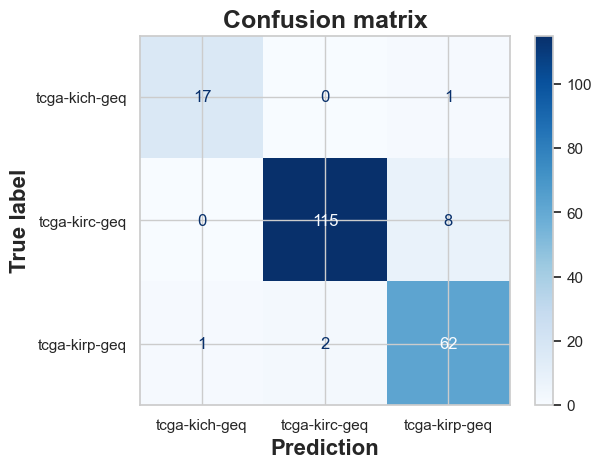

In [62]:
from sklearn.metrics import ConfusionMatrixDisplay

def plot_confusion_matrix(y_test: np.ndarray, predictions: np.ndarray, 
                          class_encoder: LabelEncoder, normalize: bool = True):
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_encoder.classes_)
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion matrix", fontweight="bold", fontsize=FONTSIZE + 2)
    plt.xlabel("Prediction", fontweight="bold", fontsize=FONTSIZE)
    plt.ylabel("True label", fontweight="bold", fontsize=FONTSIZE)
    plt.show()

plot_confusion_matrix(y_test, best_model.predictions, class_encoder)

# Pytorch Approach

In [63]:
X_train_temp = X_train
y_train_temp = y_train

X_train_balanced_temp, y_train_balanced_temp = oversampler.fit_resample(X_train_temp, y_train_temp)

In [64]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import tqdm
from torch.optim import Adam, lr_scheduler

batch_size = 64
num_epochs = 10
learning_rate = 0.0001

torch.manual_seed(SEED)

class TCGADataset(Dataset):
    def __init__(self, X: np.ndarray, y: np.ndarray):
        self.X = torch.from_numpy(X).float()
        self.y = torch.from_numpy(y).long()

    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
# oversampler
# X_train_balanced, y_train_balanced = oversampler.fit_resample(X_train, y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train_temp, y_train_temp, stratify=y_train_temp, test_size=0.1, random_state=SEED)
X_train_balanced, X_val_balanced, y_train_balanced, y_val_balanced = train_test_split(X_train_balanced_temp, y_train_balanced_temp, stratify=y_train_balanced_temp, test_size=0.1, random_state=SEED)

train_dataset = TCGADataset(X_train, y_train)
val_dataset = TCGADataset(X_val, y_val)
test_dataset = TCGADataset(X_test, y_test)

train_dataset_balanced = TCGADataset(X_train_balanced, y_train_balanced)
val_dataset_balanced = TCGADataset(X_val_balanced, y_val_balanced)


train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

train_loader_balanced = DataLoader(train_dataset_balanced, batch_size=batch_size, shuffle=True)
val_loader_balanced = DataLoader(val_dataset_balanced, batch_size=batch_size, shuffle=False)

In [65]:
class CancerDetection(nn.Module):

    def __init__(self, input_size: int, num_classes: int):
        super(CancerDetection, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),

            nn.Linear(256, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.model(x)
    
    def predict(self, x):
        out = self.forward(x)
        return torch.argmax(out, dim=1)
    
    def predict_proba(self, x):
        out = self.forward(x)
        return F.softmax(out, dim=1)
    

In [66]:
model = CancerDetection(input_size=X_train.shape[1], num_classes=np.unique(y).shape[0])
optim = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optim, step_size=4)
criterion = nn.CrossEntropyLoss()

class Metrics(NamedTuple):
    f1_score_test_macro: float
    f1_score_test_classes: np.ndarray
    mcc_score_test: float

def init_weights_xavier(model):
    if type(model) == nn.Linear:
        nn.init.xavier_uniform_(model.weight)
    if type(model) == nn.BatchNorm1d:
        nn.init.xavier_uniform_(model.weight)

def init_weights_normal(model):
    if type(model) == nn.Linear:
        nn.init.normal_(model.weight, mean=0, std=0.01)
    if type(model) == nn.BatchNorm1d:
        nn.init.normal_(model.weight, mean=0, std=0.01)

def plot_train_val_loss(train_losses: List[float], val_losses: List[float]):
    plt.figure(figsize=(6, 4))
    plt.plot(train_losses, label="Train loss")
    plt.plot(val_losses, label="Val loss")
    plt.xlabel("Epoch", fontweight="bold", fontsize=FONTSIZE)
    plt.ylabel("Loss", fontweight="bold", fontsize=FONTSIZE)
    plt.title("Train loss", fontweight="bold", fontsize=FONTSIZE + 2)
    plt.legend()
    plt.show()


def evaluate(model, test_loader: DataLoader, encoder: LabelEncoder, 
             print_res: bool = True) -> Metrics:
    
    model.eval()
    y_pred = []
    y_true = []
    for X_, y_ in test_loader:
        y_pred.extend(model.predict(X_).tolist())
        y_true.extend(y_.tolist())
    
    f1_score_macro = f1_score(y_true, y_pred, average="macro")
    f1_score_classes = f1_score(y_true, y_pred, average=None)
    mcc_score = matthews_corrcoef(y_true, y_pred)

    if print_res:
        print(f"Test f1 score: {f1_score_macro}")
        print(f"Test MCC score: {mcc_score}")
        for i, class_name in enumerate(class_encoder.classes_):
            print(f"{class_name}: {f1_score_classes[i]}")

    plot_confusion_matrix(y_true, y_pred, encoder)
    
    return Metrics(f1_score_test_macro=f1_score_macro, 
                   f1_score_test_classes=f1_score_classes,
                     mcc_score_test=mcc_score)

def train(model, train_loader: DataLoader, val_loader: DataLoader, optim: object, 
          criterion: object, scheduler: object, num_epochs: int, plot_losses: bool = True) -> CancerDetection:
    
    train_losses = []
    val_losses = []
    f1_scores = []

    best_model = None
    best_f1_score = 0

    for epoch in tqdm.tqdm(range(1, num_epochs + 1)):
        model.train()
        train_loss = 0.0
        for X_, y_ in train_loader:
            optim.zero_grad()
            outputs = model(X_)
            loss = criterion(outputs, y_)
            loss.backward()
            optim.step()
            train_loss += loss.item()

        scheduler.step()

        train_loss = train_loss / len(train_loader)
        train_losses.append(train_loss)


        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            predictions = []
            y_true = []
            for X_, y_ in val_loader:
                outputs = model(X_)
                loss = criterion(outputs, y_)
                val_loss += loss.item()

                predictions.extend(model.predict(X_).tolist())
                y_true.extend(y_.tolist())

        f1 = f1_score(y_true, predictions, average="macro")
        f1_scores.append(f1)
        val_loss = val_loss / len(val_loader)
        val_losses.append(val_loss)

        if f1 > best_f1_score:
            best_f1_score = f1
            best_model = model


        print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}")
        print(f"Epoch {epoch}, Val Loss: {val_loss:.4f}")
        print(f"Epoch {epoch}, Val f1 score: {f1:.4f}")
        print("--------------------------------------------------")

    if plot_losses:
        plot_train_val_loss(train_losses, val_losses)

    return best_model


 10%|█         | 1/10 [00:05<00:53,  5.95s/it]

Epoch 1, Train Loss: 0.8420
Epoch 1, Val Loss: 1.0003
Epoch 1, Val f1 score: 0.8802
--------------------------------------------------


 20%|██        | 2/10 [00:11<00:47,  5.91s/it]

Epoch 2, Train Loss: 0.7370
Epoch 2, Val Loss: 0.8187
Epoch 2, Val f1 score: 0.8815
--------------------------------------------------


 30%|███       | 3/10 [00:17<00:41,  5.98s/it]

Epoch 3, Train Loss: 0.6973
Epoch 3, Val Loss: 0.7376
Epoch 3, Val f1 score: 0.9346
--------------------------------------------------


 40%|████      | 4/10 [00:23<00:34,  5.78s/it]

Epoch 4, Train Loss: 0.6795
Epoch 4, Val Loss: 0.7049
Epoch 4, Val f1 score: 0.9443
--------------------------------------------------


 50%|█████     | 5/10 [00:29<00:28,  5.77s/it]

Epoch 5, Train Loss: 0.6637
Epoch 5, Val Loss: 0.6986
Epoch 5, Val f1 score: 0.9443
--------------------------------------------------


 60%|██████    | 6/10 [00:35<00:23,  5.85s/it]

Epoch 6, Train Loss: 0.6591
Epoch 6, Val Loss: 0.6919
Epoch 6, Val f1 score: 0.9126
--------------------------------------------------


 70%|███████   | 7/10 [00:42<00:18,  6.25s/it]

Epoch 7, Train Loss: 0.6557
Epoch 7, Val Loss: 0.6875
Epoch 7, Val f1 score: 0.9126
--------------------------------------------------


 80%|████████  | 8/10 [00:48<00:12,  6.32s/it]

Epoch 8, Train Loss: 0.6548
Epoch 8, Val Loss: 0.6911
Epoch 8, Val f1 score: 0.9126
--------------------------------------------------


 90%|█████████ | 9/10 [00:55<00:06,  6.55s/it]

Epoch 9, Train Loss: 0.6569
Epoch 9, Val Loss: 0.6892
Epoch 9, Val f1 score: 0.9126
--------------------------------------------------


100%|██████████| 10/10 [01:02<00:00,  6.28s/it]

Epoch 10, Train Loss: 0.6506
Epoch 10, Val Loss: 0.6896
Epoch 10, Val f1 score: 0.9126
--------------------------------------------------


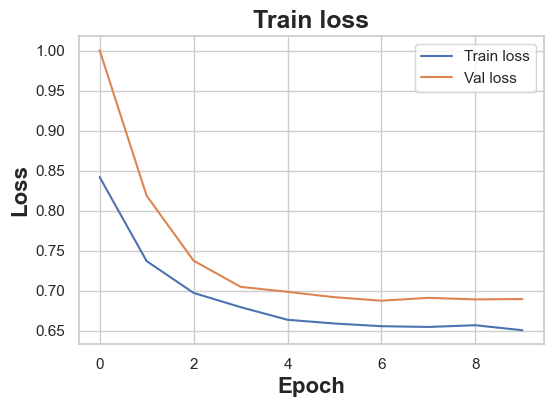

Test f1 score: 0.9286099865047234
Test MCC score: 0.9126268286525007
tcga-kich-geq: 0.8717948717948718
tcga-kirc-geq: 0.9666666666666667
tcga-kirp-geq: 0.9473684210526316


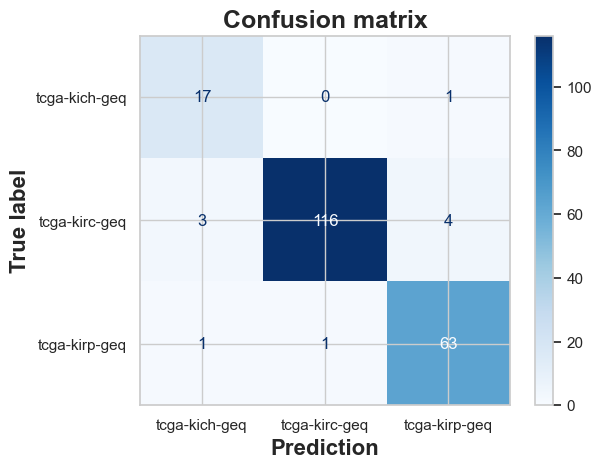

In [67]:
# init_weights_xavier(model)
model = train(model, train_loader, val_loader, optim, criterion, scheduler, num_epochs)
metrics = evaluate(model, test_loader, class_encoder)

 10%|█         | 1/10 [00:09<01:21,  9.09s/it]

Epoch 1, Train Loss: 0.8127
Epoch 1, Val Loss: 0.9576
Epoch 1, Val f1 score: 0.8866
--------------------------------------------------


 20%|██        | 2/10 [00:17<01:09,  8.74s/it]

Epoch 2, Train Loss: 0.7135
Epoch 2, Val Loss: 0.7623
Epoch 2, Val f1 score: 0.9233
--------------------------------------------------


 30%|███       | 3/10 [00:24<00:56,  8.13s/it]

Epoch 3, Train Loss: 0.6895
Epoch 3, Val Loss: 0.7223
Epoch 3, Val f1 score: 0.9081
--------------------------------------------------


 40%|████      | 4/10 [00:31<00:45,  7.61s/it]

Epoch 4, Train Loss: 0.6510
Epoch 4, Val Loss: 0.6779
Epoch 4, Val f1 score: 0.9457
--------------------------------------------------


 50%|█████     | 5/10 [00:38<00:36,  7.29s/it]

Epoch 5, Train Loss: 0.6340
Epoch 5, Val Loss: 0.6747
Epoch 5, Val f1 score: 0.9553
--------------------------------------------------


 60%|██████    | 6/10 [00:45<00:28,  7.16s/it]

Epoch 6, Train Loss: 0.6368
Epoch 6, Val Loss: 0.6747
Epoch 6, Val f1 score: 0.9553
--------------------------------------------------


 70%|███████   | 7/10 [00:52<00:21,  7.13s/it]

Epoch 7, Train Loss: 0.6365
Epoch 7, Val Loss: 0.6731
Epoch 7, Val f1 score: 0.9448
--------------------------------------------------


 80%|████████  | 8/10 [00:59<00:14,  7.13s/it]

Epoch 8, Train Loss: 0.6332
Epoch 8, Val Loss: 0.6718
Epoch 8, Val f1 score: 0.9553
--------------------------------------------------


 90%|█████████ | 9/10 [01:06<00:07,  7.09s/it]

Epoch 9, Train Loss: 0.6299
Epoch 9, Val Loss: 0.6678
Epoch 9, Val f1 score: 0.9553
--------------------------------------------------


100%|██████████| 10/10 [01:13<00:00,  7.34s/it]

Epoch 10, Train Loss: 0.6315
Epoch 10, Val Loss: 0.6721
Epoch 10, Val f1 score: 0.9342
--------------------------------------------------


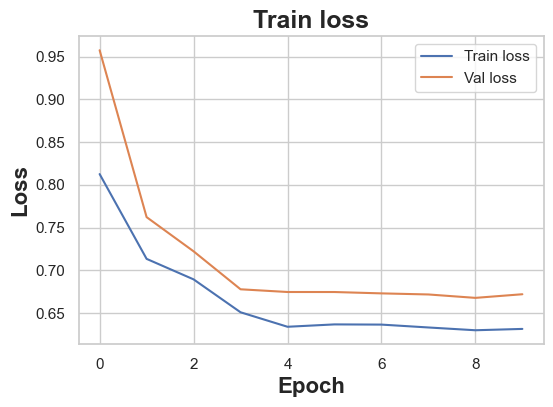

Test f1 score: 0.9326740086731351
Test MCC score: 0.9118465165288636
tcga-kich-geq: 0.8947368421052632
tcga-kirc-geq: 0.970954356846473
tcga-kirp-geq: 0.9323308270676691


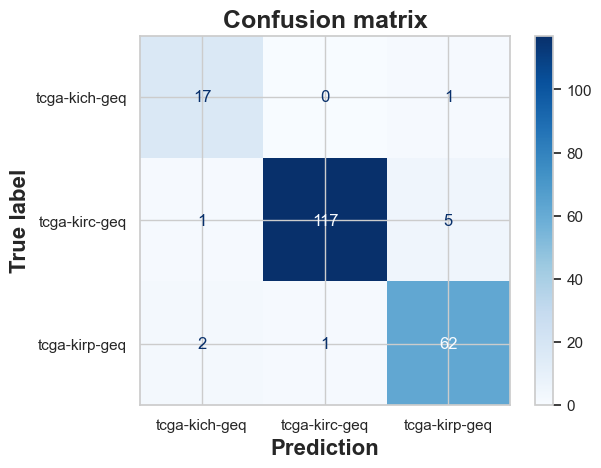

In [68]:
model = CancerDetection(input_size=X_train.shape[1], num_classes=np.unique(y).shape[0])
optim = Adam(model.parameters(), lr=learning_rate)
scheduler = lr_scheduler.StepLR(optim, step_size=4)
criterion = nn.CrossEntropyLoss()

model = train(model, train_loader_balanced, val_loader_balanced, optim, criterion, scheduler, num_epochs)
metrics = evaluate(model, test_loader, class_encoder)